# Analisis de duracion de partidos de tenis
## Estadistica aplicada 2
### Integrantes
- Juan Pablo Cordero
- Jaime Uria
- Gerardo Guerrero

# Introducción

# Introducción al Problema: Predicción de la Duración de Partidos de Tenis

## Contexto del Problema

En el mundo del tenis profesional, la duración de un partido es una variable crucial que impacta múltiples aspectos de este deporte. Desde la planificación de transmisiones televisivas hasta la preparación física de los jugadores, conocer con anticipación cuánto tiempo durará un encuentro representa un valor significativo para diferentes stakeholders.

Los partidos de tenis pueden variar dramáticamente en duración: desde encuentros que se resuelven en menos de una hora hasta épicas batallas que se extienden por más de cinco horas. Esta variabilidad está influenciada por múltiples factores como el formato del torneo (mejor de 3 o 5 sets), la superficie de juego, las características de los jugadores involucrados, y la etapa del torneo en la que se desarrolla el partido.

## Relevancia del Problema

La predicción precisa de la duración de partidos de tenis tiene implicaciones prácticas importantes:

### 1. **Gestión de Transmisiones y Media**
- Las cadenas televisivas necesitan planificar su programación con precisión
- Los servicios de streaming requieren estimaciones para optimizar la asignación de recursos
- La planificación publicitaria se beneficia de predicciones más exactas

### 2. **Operaciones de Torneos**
- Programación eficiente de partidos en las diferentes canchas
- Gestión de personal (árbitros, recogepelotas, personal médico)
- Planificación logística para espectadores (transporte, catering, etc.)

### 3. **Preparación de Jugadores y Entrenadores**
- Estrategias de preparación física específicas
- Planificación nutricional e hidratación
- Gestión de energía durante torneos largos

## Preguntas de Investigación

Este análisis estadístico busca responder las siguientes preguntas de investigación:

### Pregunta Principal:
**¿Es posible predecir la duración de un partido de tenis utilizando únicamente información disponible antes de que comience el encuentro?**

### Preguntas Específicas:

1. **¿Qué variables pre-partido tienen mayor influencia en la duración del encuentro?**
   - ¿Cómo afecta el formato del partido (mejor de 3 vs. 5 sets)?
   - ¿Cuál es el impacto de la superficie de juego (arcilla, césped, pista dura)?
   - ¿La etapa del torneo influye en la duración esperada?

2. **¿Las características de los jugadores son predictores significativos?**
   - ¿La diferencia de ranking entre jugadores afecta la duración?
   - ¿La edad de los competidores tiene relevancia predictiva?

3. **¿Existen patrones específicos según el nivel del torneo?**
   - ¿Los Grand Slams tienen comportamientos diferentes a otros torneos?
   - ¿Cómo varían las duraciones entre Masters 1000?

4. **¿Qué nivel de precisión es alcanzable en estas predicciones?**
   - ¿Cuál es el error promedio esperado en las predicciones?
   - ¿Existen ciertos tipos de partidos más predecibles que otros?

## Enfoque Metodológico

Para abordar estas preguntas, utilizaremos técnicas de modelado estadístico, específicamente regresión lineal, aplicadas a un dataset histórico de partidos de tenis profesional masculino. El análisis se centrará en variables disponibles antes del inicio del partido, evitando cualquier filtración de información (data leakage) que comprometería la aplicabilidad práctica del modelo.

Este enfoque nos permitirá no solo desarrollar un modelo predictivo funcional, sino también generar insights valiosos sobre los factores que determinan la duración de los encuentros tenísticos en el circuito profesional.

# Importamos las librerías necesarias


In [103]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1) Load the CSV
matches = pd.read_csv("atp_data/atp_matches_till_2022.csv")


# Vemos los valores faltantes que se ven en el DF

In [104]:
# 2) Inspect and clean
print(matches['minutes'].describe())      # look at distribution & missing
print(matches['minutes'].isna().sum())  # check for missing values
nan_percentage = matches['minutes'].isna().mean() * 100
print(f"Percentage of NaN values in 'minutes': {nan_percentage:.2f}%")  # check for missing values
# Method 1: Get total length of the DataFrame or column
total_count = len(matches['minutes'])
print(f"Total records (including NaN): {total_count}")


count    89511.000000
mean       103.497403
std         39.365772
min          0.000000
25%         75.000000
50%         96.000000
75%        125.000000
max       1146.000000
Name: minutes, dtype: float64
98650
Percentage of NaN values in 'minutes': 52.43%
Total records (including NaN): 188161


# Tiramos los partidos que no tienen duracion

In [105]:
df = matches.dropna(subset=['minutes'])   # drop matches without a duration

# Variables del Dataset de Tenis - Descripción

| Variable | Descripción | Tipo | Valores |
|----------|-------------|------|---------|
| `tourney_id` | Identificador único del torneo | String | Alfanumérico |
| `tourney_name` | Nombre del torneo | String | Texto |
| `surface` | Superficie en la que se juega el partido | Categórica | Grass, Carpet, Clay, Hard |
| `draw_size` | Tamaño del cuadro del torneo | Numérico | Entero (32, 64, 128, etc.) |
| `tourney_level` | Nivel del torneo | Categórica | G = Grand Slams<br>M = Masters 1000<br>A = Otros eventos ATP Tour<br>C = Challengers<br>S = Satellites/ITFs<br>F = Finales de temporada<br>D = Copa Davis |
| `tourney_date` | Fecha de inicio del torneo | Fecha | YYYYMMDD |
| `match_num` | Número de partido en un torneo específico | Numérico | Entero |
| `id` | Identificador del jugador | String | Alfanumérico |
| `seed` | Cabeza de serie del jugador en el torneo | Numérico | Entero o NaN |
| `entry` | Forma de entrada al torneo | Categórica | WC = Wildcard<br>Q = Clasificado<br>LL = Lucky loser<br>PR = Protected ranking<br>SE = Special Exempt<br>ALT = Alternate player |
| `name` | Nombre del jugador | String | Texto |
| `hand` | Mano dominante del jugador | Categórica | R = Diestro<br>L = Zurdo |
| `ht` | Altura del jugador | Numérico | Entero (en cm) |
| `IOC` | País de origen (código olímpico) | Categórica | Códigos de 3 letras |
| `age` | Edad del jugador | Numérico | Decimal |
| `score` | Resultado final del partido | String | Texto formateado |
| `best_of` | Número máximo de sets en el partido | Numérico | 3 o 5 |
| `round` | Ronda del torneo | Categórica | R128 = Ronda de 128<br>R64 = Ronda de 64<br>R32 = Ronda de 32<br>R16 = Octavos de final<br>QF = Cuartos de final<br>SF = Semifinales<br>F = Final<br>RR = Round Robin<br>ER = Early Round<br>BR = Bronze medal match |
| `minutes` | Duración del partido en minutos | Numérico | Entero |
| `ace` | Número de aces en el partido | Numérico | Entero |
| `df` | Dobles faltas | Numérico | Entero |
| `svpt` | Puntos de servicio | Numérico | Entero |
| `1stin` | Primer servicio dentro (cantidad) | Numérico | Entero |
| `1stWon` | Puntos ganados con primer servicio | Numérico | Entero |
| `2ndWon` | Puntos ganados con segundo servicio | Numérico | Entero |
| `SvGms` | Número de juegos al servicio | Numérico | Entero |
| `bpSaved` | Puntos de break salvados | Numérico | Entero |
| `bpFaced` | Puntos de break enfrentados | Numérico | Entero |

## Notas Adicionales:

- Para las estadísticas de partido (ace, df, svpt, etc.), hay dos versiones de cada variable:
  - Prefijo `w_` para el ganador del partido (winner)
  - Prefijo `l_` para el perdedor del partido (loser)

# Nota:
### Solo nos vamos a centrar en los torneos Grand Slams y Masters 1000

In [106]:
t_lev = ["G", "M"]

df = df[df['tourney_level'].isin(t_lev)]  # filter for Grand Slam and Masters tournaments
display(df['tourney_level'].value_counts())  # check the distribution of tournament levels

tourney_level
M    16915
G    14254
Name: count, dtype: int64

### Confirmamos que los torneos son Grand Slams y Masters 1000

In [107]:
# convert all tournament names to lowercase and strip whitespace
df['tourney_name'] = df['tourney_name'].str.lower().str.strip()

# verify
sorted(df['tourney_name'].unique())


['australian open',
 'canada masters',
 'cincinnati masters',
 'essen masters',
 'hamburg masters',
 'indian wells masters',
 'madrid masters',
 'miami masters',
 'monte carlo masters',
 'paris masters',
 'roland garros',
 'rome masters',
 'shanghai masters',
 'stockholm masters',
 'stuttgart masters',
 'us open',
 'wimbledon']

### Poner la fecha en formato correcto

In [108]:
# if tourney_date is int, first convert to string
df['tourney_date'] = pd.to_datetime(
    df['tourney_date'].astype(str),
    format='%Y%m%d'
)
# now verify
print(df['tourney_date'].dtype)
print(df['tourney_date'].head())


datetime64[ns]
85972   1991-01-14
85973   1991-01-14
85974   1991-01-14
85975   1991-01-14
85976   1991-01-14
Name: tourney_date, dtype: datetime64[ns]


# Eliminamos las columnas que no nos interesan

In [ ]:
df = df.drop(columns=['match_num'])
df = df.drop(columns=["winner_entry", "loser_entry"])  # drop the entry columns
df = df.drop(columns=["winner_ioc", "loser_ioc"])  # drop the ioc columns
display(df.head())  # check the first few rows of the DataFrame

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,winner_id,winner_seed,winner_name,winner_hand,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
85972,1991-580,australian open,Hard,128,G,1991-01-14,101222,1.0,Stefan Edberg,R,...,72.0,43.0,11.0,14.0,4.0,10.0,1.0,3889.0,162.0,202.0
85973,1991-580,australian open,Hard,128,G,1991-01-14,100995,NaN,Eduardo Masso,L,...,110.0,67.0,29.0,26.0,7.0,18.0,124.0,278.0,81.0,453.0
85974,1991-580,australian open,Hard,128,G,1991-01-14,101138,NaN,Pat Cash,R,...,59.0,31.0,12.0,12.0,9.0,16.0,84.0,432.0,32.0,845.0
85975,1991-580,australian open,Hard,128,G,1991-01-14,100870,NaN,Christo Van Rensburg,R,...,49.0,26.0,26.0,14.0,8.0,15.0,59.0,527.0,82.0,448.0
85976,1991-580,australian open,Hard,128,G,1991-01-14,101731,NaN,Nuno Marques,L,...,77.0,57.0,28.0,23.0,9.0,13.0,104.0,340.0,116.0,299.0


In [110]:
# Variables que causan data leakage (solo conocidas después del partido)
data_leakage_columns = [
    # Estadísticas de servicio del ganador
    'w_svpt',       # Puntos de servicio ganador
    'w_1stIn',      # Primeros servicios dentro ganador  
    'w_1stWon',     # Puntos ganados con primer servicio ganador
    'w_2ndWon',     # Puntos ganados con segundo servicio ganador
    'w_SvGms',      # Juegos al servicio ganador
    'w_ace',        # Aces ganador
    'w_df',         # Dobles faltas ganador
    'w_bpFaced',    # Break points enfrentados ganador
    'w_bpSaved',    # Break points salvados ganador
    
    # Estadísticas de servicio del perdedor
    'l_svpt',       # Puntos de servicio perdedor
    'l_1stIn',      # Primeros servicios dentro perdedor
    'l_1stWon',     # Puntos ganados con primer servicio perdedor
    'l_2ndWon',     # Puntos ganados con segundo servicio perdedor
    'l_SvGms',      # Juegos al servicio perdedor
    'l_ace',        # Aces perdedor
    'l_df',         # Dobles faltas perdedor
    'l_bpFaced',    # Break points enfrentados perdedor
    'l_bpSaved',    # Break points salvados perdedor
    
    # Resultado del partido
    'score',        # Marcador final
    
    # Variables de identificación con información post-partido
    'winner_rank_points',  # Puntos de ranking ganador (pueden cambiar post-partido)
    'loser_rank_points'    # Puntos de ranking perdedor (pueden cambiar post-partido)
]

# Verificar qué columnas existen realmente en el DataFrame
existing_leakage_columns = [col for col in data_leakage_columns if col in df.columns]

# Eliminar las columnas con data leakage
df_clean = df.drop(columns=existing_leakage_columns)
# Mostrar las columnas que quedan disponibles para predecir
print("\nColumnas disponibles para predicción (sin data leakage):")
remaining_columns = sorted(df_clean.columns.tolist())
for i, col in enumerate(remaining_columns, 1):
    print(f"{i:2d}. {col}")

df = df_clean.copy()


Columnas disponibles para predicción (sin data leakage):
 1. best_of
 2. draw_size
 3. loser_age
 4. loser_hand
 5. loser_ht
 6. loser_id
 7. loser_name
 8. loser_rank
 9. loser_seed
10. minutes
11. round
12. surface
13. tourney_date
14. tourney_id
15. tourney_level
16. tourney_name
17. winner_age
18. winner_hand
19. winner_ht
20. winner_id
21. winner_name
22. winner_rank
23. winner_seed


# Despues de tirar algunas variables ahora vamos con las que consideramos las mas imporantes dentro del modelo

In [111]:
# =============================================================================
# PASO 1: SELECCIONAR VARIABLES ALTAMENTE RELEVANTES
# =============================================================================

# Variables altamente relevantes para predicir duración del partido
highly_relevant_vars = [
    # Características del formato del partido
    'best_of',          # 3 o 5 sets
    'surface',          # Grass, Clay, Hard, Carpet
    'round',            # Ronda del torneo
    'tourney_level',    # G, M, A, C, S, F, D
    
    # Características de los jugadores
    'winner_rank',      # Ranking ganador
    'loser_rank',       # Ranking perdedor
    'winner_age',       # Edad ganador
    'loser_age',        # Edad perdedor
    'winner_seed',      # Seed ganador
    'loser_seed',       # Seed perdedor
    
    # Variable target
    'minutes'           # Duración del partido
]

# Crear DataFrame con solo variables relevantes
df_model = df[highly_relevant_vars].copy()


In [112]:
# =============================================================================
# ANÁLISIS DE VALORES FALTANTES
# =============================================================================

print("=== ANÁLISIS DE VALORES FALTANTES ===\n")

# Contar valores faltantes por columna
missing_counts = df_model.isna().sum()
missing_percentages = (df_model.isna().sum() / len(df_model)) * 100

# Crear DataFrame con la información de valores faltantes
missing_info = pd.DataFrame({
    'Variable': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percentage': missing_percentages.values,
    'Non_Missing_Count': len(df_model) - missing_counts.values
})

# Ordenar por porcentaje de valores faltantes (descendente)
missing_info = missing_info.sort_values('Missing_Percentage', ascending=False)

print("RESUMEN DE VALORES FALTANTES:")
print("=" * 60)
for idx, row in missing_info.iterrows():
    print(f"{row['Variable']:<15} | Missing: {row['Missing_Count']:>6,} ({row['Missing_Percentage']:>6.2f}%) | Available: {row['Non_Missing_Count']:>6,}")

print("=" * 60)
print(f"Total de filas en el dataset: {len(df_model):,}")

# Mostrar estadísticas adicionales
print(f"\nVARIABLES SIN VALORES FALTANTES:")
no_missing = missing_info[missing_info['Missing_Count'] == 0]['Variable'].tolist()
if no_missing:
    for var in no_missing:
        print(f"  ✓ {var}")
else:
    print("  Ninguna variable está completa")

print(f"\nVARIABLES CON VALORES FALTANTES:")
with_missing = missing_info[missing_info['Missing_Count'] > 0]
if len(with_missing) > 0:
    for idx, row in with_missing.iterrows():
        print(f"  ⚠️  {row['Variable']}: {row['Missing_Percentage']:.2f}% faltante")
else:
    print("  Todas las variables están completas")

# Análisis más detallado para cada variable con faltantes
print("\n=== ANÁLISIS DETALLADO DE VARIABLES CON FALTANTES ===")
for idx, row in with_missing.iterrows():
    var_name = row['Variable']
    if var_name != 'minutes':  # No analizar la variable target aún
        print(f"\n{var_name.upper()}:")
        print(f"  - Total faltantes: {row['Missing_Count']:,}")
        print(f"  - Porcentaje faltante: {row['Missing_Percentage']:.2f}%")
        
        # Mostrar distribución de valores no faltantes
        non_null_values = df_model[var_name].dropna()
        if len(non_null_values) > 0:
            if df_model[var_name].dtype in ['int64', 'float64']:
                print(f"  - Estadísticas de valores disponibles:")
                print(f"    * Media: {non_null_values.mean():.2f}")
                print(f"    * Mediana: {non_null_values.median():.2f}")
                print(f"    * Min: {non_null_values.min()}")
                print(f"    * Max: {non_null_values.max()}")
            else:
                print(f"  - Valores únicos disponibles: {non_null_values.nunique()}")
                print(f"  - Valores más frecuentes:")
                top_values = non_null_values.value_counts().head(3)
                for value, count in top_values.items():
                    pct = (count / len(non_null_values)) * 100
                    print(f"    * {value}: {count:,} ({pct:.1f}%)")

# Análisis especial para la variable target
if 'minutes' in with_missing['Variable'].values:
    print(f"\nVARIABLE TARGET (minutes):")
    minutes_missing = missing_info[missing_info['Variable'] == 'minutes'].iloc[0]
    print(f"  - Faltantes: {minutes_missing['Missing_Count']:,} ({minutes_missing['Missing_Percentage']:.2f}%)")
    print(f"  - Disponibles: {minutes_missing['Non_Missing_Count']:,}")
    print(f"  - DECISIÓN: Eliminar filas con minutes faltantes (es nuestra variable target)")

=== ANÁLISIS DE VALORES FALTANTES ===

RESUMEN DE VALORES FALTANTES:
loser_seed      | Missing: 23,475 ( 75.32%) | Available:  7,694
winner_seed     | Missing: 16,231 ( 52.07%) | Available: 14,938
loser_rank      | Missing:     87 (  0.28%) | Available: 31,082
winner_rank     | Missing:     39 (  0.13%) | Available: 31,130
best_of         | Missing:      0 (  0.00%) | Available: 31,169
surface         | Missing:      0 (  0.00%) | Available: 31,169
round           | Missing:      0 (  0.00%) | Available: 31,169
tourney_level   | Missing:      0 (  0.00%) | Available: 31,169
winner_age      | Missing:      0 (  0.00%) | Available: 31,169
loser_age       | Missing:      0 (  0.00%) | Available: 31,169
minutes         | Missing:      0 (  0.00%) | Available: 31,169
Total de filas en el dataset: 31,169

VARIABLES SIN VALORES FALTANTES:
  ✓ best_of
  ✓ surface
  ✓ round
  ✓ tourney_level
  ✓ winner_age
  ✓ loser_age
  ✓ minutes

VARIABLES CON VALORES FALTANTES:
  ⚠️  loser_seed: 75.32% falt

# Dado que hay tantos valores faltantes en la variable 'loser_seed' y 'winner_seed' decidimos eliminarla

In [113]:
df_model = df_model.drop(columns=["loser_seed" , "winner_seed"])  # Eliminar la variable loser_seed

In [114]:
# I want to drop the rows with missing values in the columns winner_rank and loser_rank
df_model = df_model.dropna(subset=['winner_rank', 'loser_rank'])
# Eliminar filas con valores faltantes en la variable target

In [115]:

# =============================================================================
# PASO 2: FEATURE ENGINEERING
# =============================================================================

print(f"--- FEATURE ENGINEERING ---")

# 2.1 Crear diferencias de ranking y edad
df_model['rank_diff'] = abs(df_model['winner_rank'] - df_model['loser_rank'])
df_model['avg_rank'] = (df_model['winner_rank'] + df_model['loser_rank']) / 2
df_model['min_rank'] = np.minimum(df_model['winner_rank'], df_model['loser_rank'])
print("✓ Variables de ranking creadas")

df_model['age_diff'] = abs(df_model['winner_age'] - df_model['loser_age'])
df_model['avg_age'] = (df_model['winner_age'] + df_model['loser_age']) / 2
print("✓ Variables de edad creadas")

# 2.2 Indicadores de paridad
df_model['close_ranking'] = (df_model['rank_diff'] < 50).astype(int)
print("✓ Variables de paridad creadas")

--- FEATURE ENGINEERING ---
✓ Variables de ranking creadas
✓ Variables de edad creadas
✓ Variables de paridad creadas


In [116]:
display(df_model.head())  # check the first few rows of the DataFrame

,best_of,surface,round,tourney_level,winner_rank,loser_rank,winner_age,loser_age,minutes,rank_diff,avg_rank,min_rank,age_diff,avg_age,close_ranking
85972,5,Hard,R128,G,1.0,162.0,24.9,22.9,114.0,161.0,81.5,1.0,2.0,23.90,0
85973,5,Hard,R128,G,124.0,81.0,27.0,24.8,220.0,43.0,102.5,81.0,2.2,25.90,1
85974,5,Hard,R128,G,84.0,32.0,25.6,25.7,110.0,52.0,58.0,32.0,0.1,25.65,0
85975,5,Hard,R128,G,59.0,82.0,28.2,24.6,117.0,23.0,70.5,59.0,3.6,26.40,1
85976,5,Hard,R128,G,104.0,116.0,20.7,23.1,178.0,12.0,110.0,104.0,2.4,21.90,1


In [7]:
from limpieza import cleaned_data

df = cleaned_data
display(df.head())  # check the first few rows of the DataFrame

,best_of,surface,round,tourney_level,winner_rank,loser_rank,winner_age,loser_age,minutes,rank_diff,avg_rank,min_rank,age_diff,avg_age,close_ranking
85972,5,Hard,R128,G,1.0,162.0,24.9,22.9,114.0,161.0,81.5,1.0,2.0,23.90,0
85973,5,Hard,R128,G,124.0,81.0,27.0,24.8,220.0,43.0,102.5,81.0,2.2,25.90,1
85974,5,Hard,R128,G,84.0,32.0,25.6,25.7,110.0,52.0,58.0,32.0,0.1,25.65,0
85975,5,Hard,R128,G,59.0,82.0,28.2,24.6,117.0,23.0,70.5,59.0,3.6,26.40,1
85976,5,Hard,R128,G,104.0,116.0,20.7,23.1,178.0,12.0,110.0,104.0,2.4,21.90,1


In [8]:
print(sorted(df.columns.tolist()))  # check the columns of the DataFrame

['age_diff', 'avg_age', 'avg_rank', 'best_of', 'close_ranking', 'loser_age', 'loser_rank', 'min_rank', 'minutes', 'rank_diff', 'round', 'surface', 'tourney_level', 'winner_age', 'winner_rank']


# Queremos checar los supuestos de la regresion lineal

In [31]:
from limpieza import cleaned_data

df = cleaned_data
display(df.head())  # check the first few rows of the DataFrame

,best_of,surface,round,tourney_level,winner_rank,loser_rank,winner_age,loser_age,minutes,rank_diff,avg_rank,min_rank,age_diff,avg_age,close_ranking
85972,5,Hard,R128,G,1.0,162.0,24.9,22.9,114.0,161.0,81.5,1.0,2.0,23.90,0
85973,5,Hard,R128,G,124.0,81.0,27.0,24.8,220.0,43.0,102.5,81.0,2.2,25.90,1
85974,5,Hard,R128,G,84.0,32.0,25.6,25.7,110.0,52.0,58.0,32.0,0.1,25.65,0
85975,5,Hard,R128,G,59.0,82.0,28.2,24.6,117.0,23.0,70.5,59.0,3.6,26.40,1
85976,5,Hard,R128,G,104.0,116.0,20.7,23.1,178.0,12.0,110.0,104.0,2.4,21.90,1


In [32]:
# ✅ Replace 'Carpet' with 'Hard' in the 'surface' column
df['surface'] = df['surface'].replace('Carpet', 'Hard')

# ✅ Verify the change
print(df['surface'].value_counts())


surface
Hard     18559
Clay      8946
Grass     3538
Name: count, dtype: int64


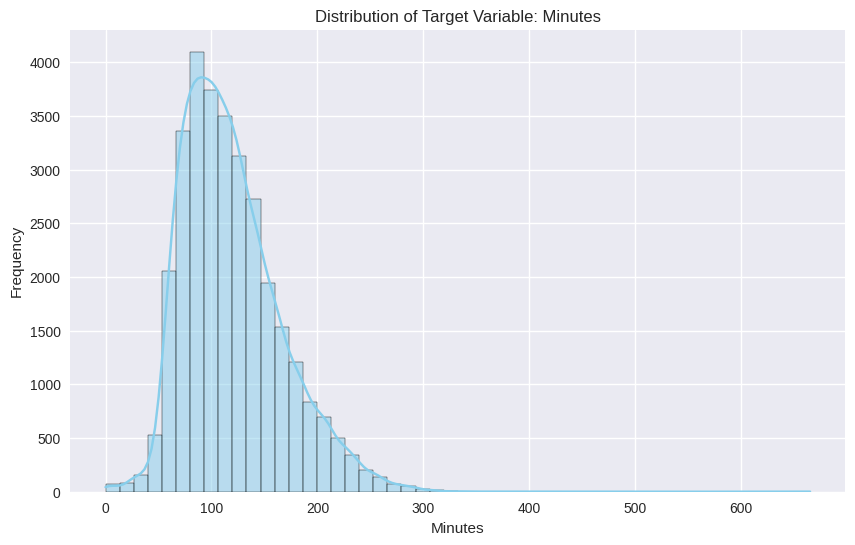

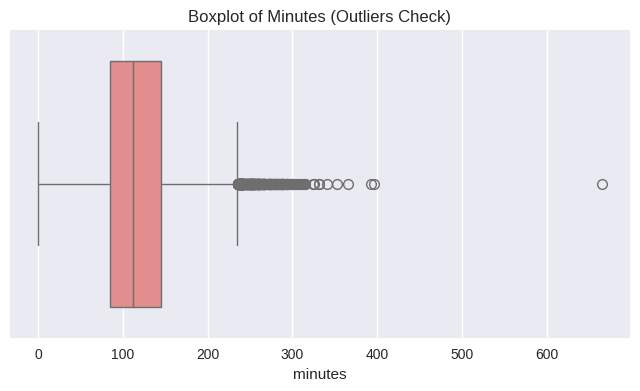

📊 Minutes - Basic Statistics:
Mean: 119.23
Median: 112.00
Standard Deviation: 46.60
Min: 0.0
Max: 665.0


In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- Distribution Plot ----------
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=50, kde=True, color='skyblue')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable: Minutes')
plt.show()

# ---------- Boxplot to Visualize Outliers ----------
plt.figure(figsize=(8, 4))
sns.boxplot(x=y, color='lightcoral')
plt.title('Boxplot of Minutes (Outliers Check)')
plt.show()

# ---------- Print Basic Stats ----------
print(f"📊 Minutes - Basic Statistics:")
print(f"Mean: {y.mean():.2f}")
print(f"Median: {y.median():.2f}")
print(f"Standard Deviation: {y.std():.2f}")
print(f"Min: {y.min()}")
print(f"Max: {y.max()}")


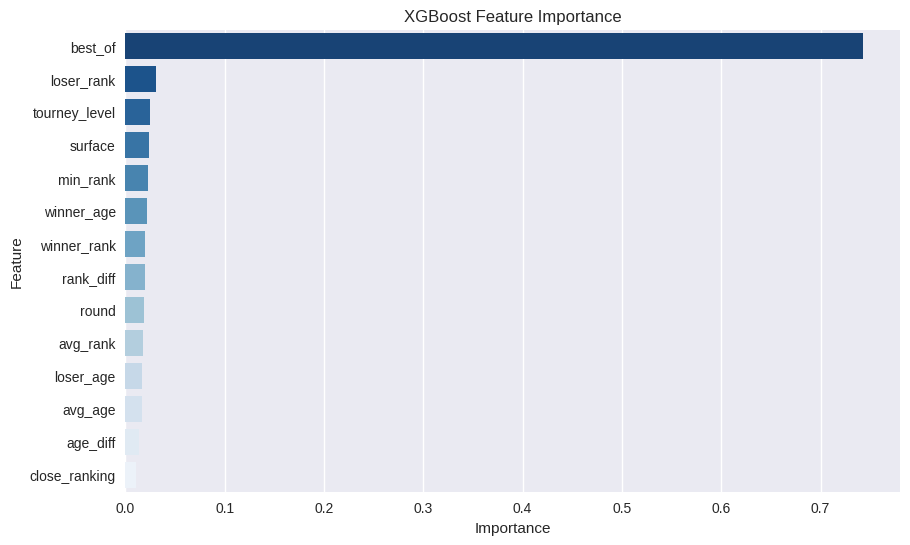


📊 Feature Importance Table:

          Feature  Importance
3         best_of    0.743286
6      loser_rank    0.030493
11  tourney_level    0.024509
10        surface    0.023966
7        min_rank    0.022998
12     winner_age    0.021322
13    winner_rank    0.020158
8       rank_diff    0.019361
9           round    0.018614
2        avg_rank    0.017438
5       loser_age    0.016846
1         avg_age    0.016708
0        age_diff    0.013987
4   close_ranking    0.010312


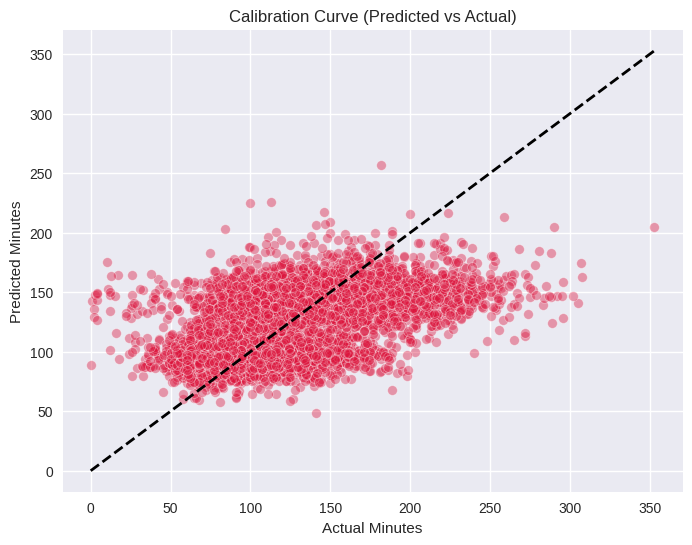


📈 Regression Performance Metrics:
R² Score: 0.2437
RMSE: 40.36 Minutes


In [37]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# ---------- 1. Prepare Data ----------
features = ['age_diff', 'avg_age', 'avg_rank', 'best_of', 'close_ranking', 
             'loser_age', 'loser_rank', 'min_rank', 'rank_diff', 
             'round', 'surface', 'tourney_level', 'winner_age', 'winner_rank']

target = 'minutes'

X = df[features].copy()
y = df[target]

# Replace 'Carpet' with 'Hard' if not already done
X['surface'] = X['surface'].replace('Carpet', 'Hard')

# ---------- 2. Encode Categorical Variables ----------
categorical_vars = ['round', 'surface', 'tourney_level']
for col in categorical_vars:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# ---------- 3. Train/Test Split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------- 4. Train XGBoost Regressor ----------
model = xgb.XGBRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# ---------- 5. Feature Importance ----------
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_r')
plt.title('XGBoost Feature Importance')
plt.show()

print("\n📊 Feature Importance Table:\n")
print(importance_df)

# ---------- 6. Predictions ----------
y_pred = model.predict(X_test)

# ---------- 7. Calibration Curve (Predicted vs. Actual) ----------
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4, color='crimson')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Minutes')
plt.ylabel('Predicted Minutes')
plt.title('Calibration Curve (Predicted vs Actual)')
plt.show()

# ---------- 8. Regression Metrics ----------
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n📈 Regression Performance Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f} Minutes")


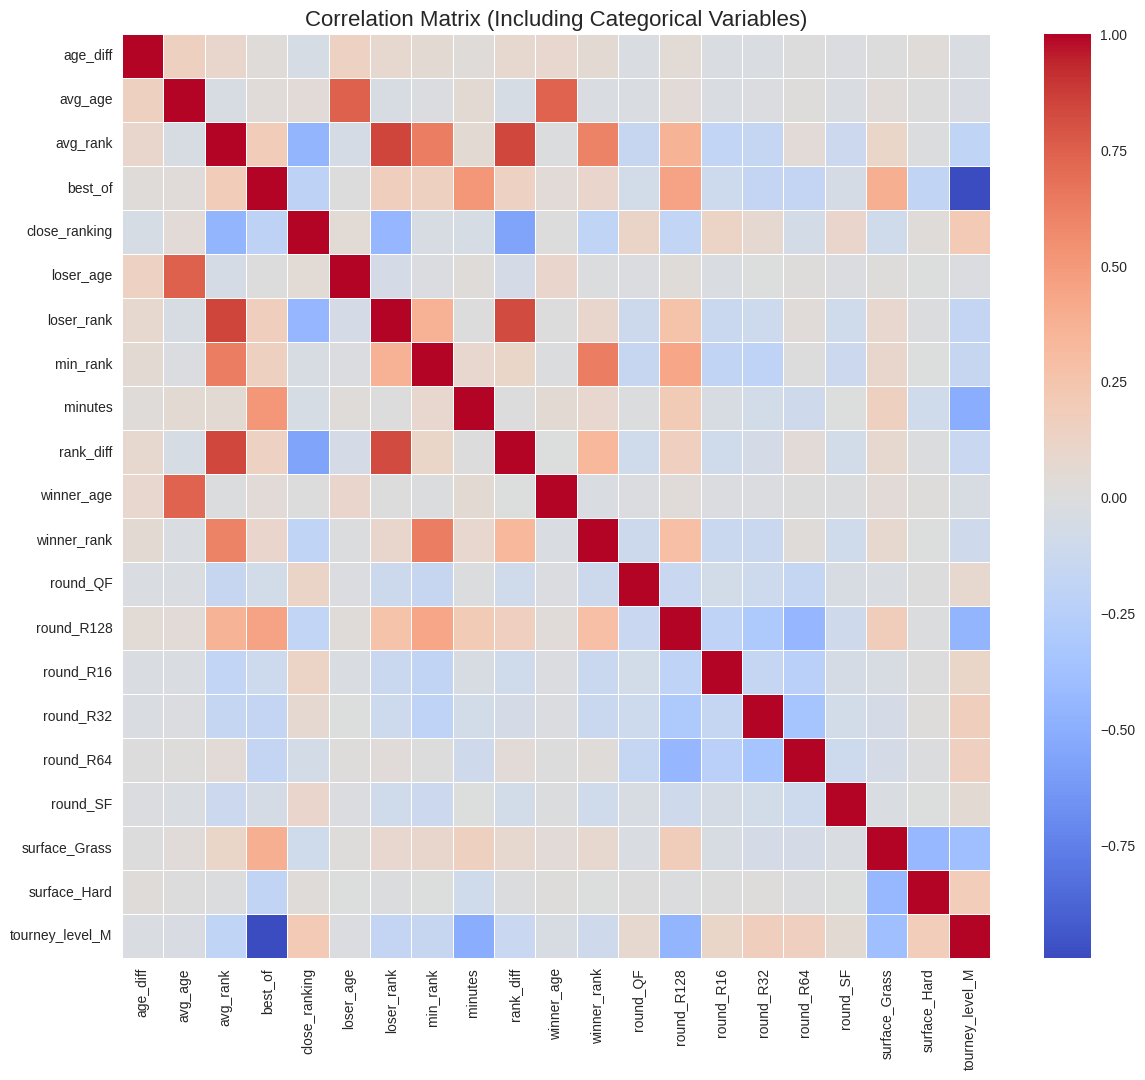

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- 1. Select the Relevant Columns ----------
features = ['age_diff', 'avg_age', 'avg_rank', 'best_of', 'close_ranking', 
             'loser_age', 'loser_rank', 'min_rank', 'minutes', 'rank_diff', 
             'round', 'surface', 'tourney_level', 'winner_age', 'winner_rank']

df_corr = df[features].copy()

# ---------- 2. One-Hot Encode Categorical Variables ----------
categorical_vars = ['round', 'surface', 'tourney_level']
df_corr = pd.get_dummies(df_corr, columns=categorical_vars, drop_first=True)

# ---------- 3. Compute the Correlation Matrix ----------
corr_matrix = df_corr.corr()

# ---------- 4. Plot the Heatmap ----------
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix (Including Categorical Variables)', fontsize=16)
plt.show()



📊 Feature-Target Correlations with 'minutes':

best_of          0.512010
winner_rank      0.086541
min_rank         0.085137
winner_age       0.053275
avg_rank         0.052405
avg_age          0.050918
loser_age        0.022638
age_diff         0.020057
loser_rank       0.007763
rank_diff        0.007217
close_ranking   -0.047277
surface         -0.053461
round           -0.159043
tourney_level   -0.507738
Name: minutes, dtype: float64


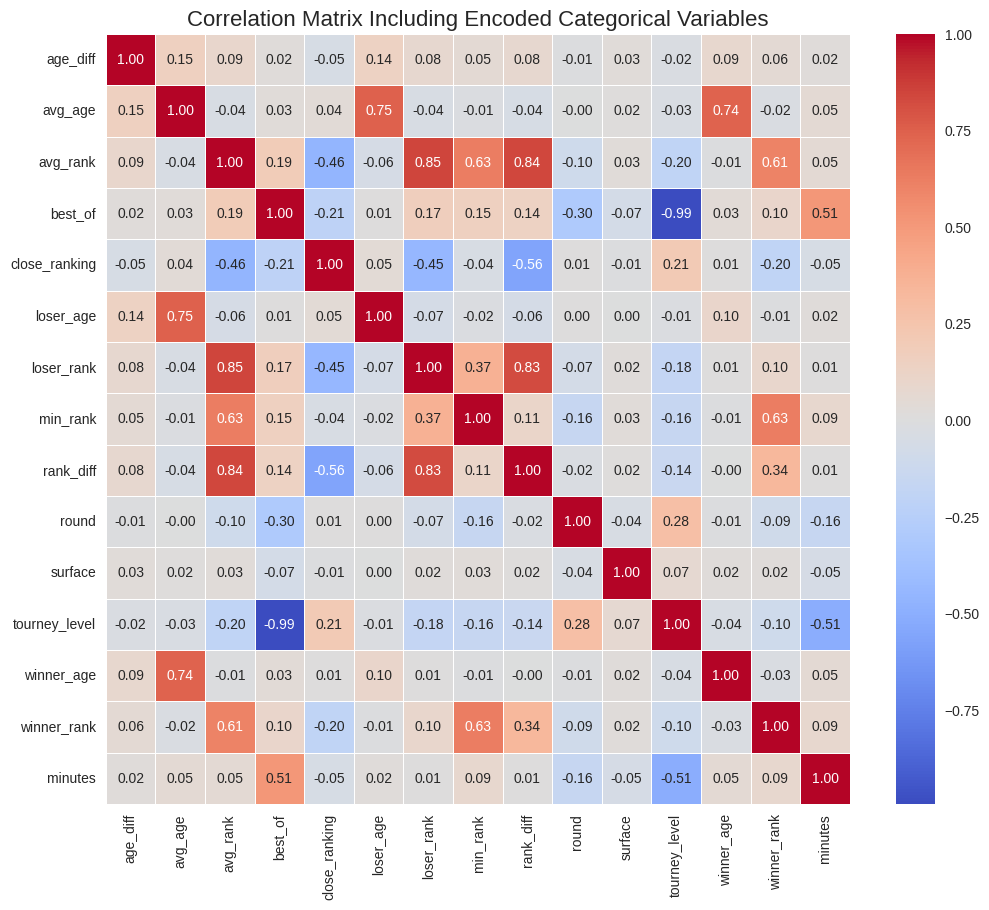

In [41]:
from sklearn.preprocessing import LabelEncoder

# 1. Prepare Data
features = ['age_diff', 'avg_age', 'avg_rank', 'best_of', 'close_ranking', 
             'loser_age', 'loser_rank', 'min_rank', 'rank_diff', 'round', 
             'surface', 'tourney_level', 'winner_age', 'winner_rank']

corr_df = df[features + ['minutes']].copy()

# 2. Encode Categorical Variables
categorical_vars = ['round', 'surface', 'tourney_level']
for col in categorical_vars:
    le = LabelEncoder()
    corr_df[col] = le.fit_transform(corr_df[col])

# 3. Compute Correlation Matrix
corr_matrix = corr_df.corr()

# 4. Display Feature-Target Correlation with 'minutes'
feature_corrs = corr_matrix['minutes'].drop('minutes')
print("\n📊 Feature-Target Correlations with 'minutes':\n")
print(feature_corrs.sort_values(ascending=False))

# 5. Optional: Plot Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Including Encoded Categorical Variables', fontsize=16)
plt.show()


In [43]:
from sklearn.preprocessing import LabelEncoder

# 1. Prepare Data
features = ['age_diff', 'avg_age', 'avg_rank', 'best_of', 'close_ranking', 
             'loser_age', 'loser_rank', 'min_rank', 'rank_diff', 'round', 
             'surface', 'tourney_level', 'winner_age', 'winner_rank']

corr_df = df[features + ['minutes']].copy()

# 2. Encode Categorical Variables
categorical_vars = ['round', 'surface', 'tourney_level']
for col in categorical_vars:
    le = LabelEncoder()
    corr_df[col] = le.fit_transform(corr_df[col])

# 3. Compute Correlations
corrs = corr_df.corr()['minutes'].drop('minutes')

# 4. Show Sorted Correlations
print("\n📊 Feature-Target Pearson Correlations with 'minutes':\n")
print(corrs.sort_values(ascending=False))



📊 Feature-Target Pearson Correlations with 'minutes':

best_of          0.512010
winner_rank      0.086541
min_rank         0.085137
winner_age       0.053275
avg_rank         0.052405
avg_age          0.050918
loser_age        0.022638
age_diff         0.020057
loser_rank       0.007763
rank_diff        0.007217
close_ranking   -0.047277
surface         -0.053461
round           -0.159043
tourney_level   -0.507738
Name: minutes, dtype: float64


In [27]:
display(df_corr.head())  # check the first few rows of the DataFrame

,age_diff,avg_age,avg_rank,best_of,close_ranking,loser_age,loser_rank,min_rank,minutes,rank_diff,...,round_QF,round_R128,round_R16,round_R32,round_R64,round_SF,surface_Clay,surface_Grass,surface_Hard,tourney_level_M
85972,2.0,23.90,81.5,5,0,22.9,162.0,1.0,114.0,161.0,...,False,True,False,False,False,False,False,False,True,False
85973,2.2,25.90,102.5,5,1,24.8,81.0,81.0,220.0,43.0,...,False,True,False,False,False,False,False,False,True,False
85974,0.1,25.65,58.0,5,0,25.7,32.0,32.0,110.0,52.0,...,False,True,False,False,False,False,False,False,True,False
85975,3.6,26.40,70.5,5,1,24.6,82.0,59.0,117.0,23.0,...,False,True,False,False,False,False,False,False,True,False
85976,2.4,21.90,110.0,5,1,23.1,116.0,104.0,178.0,12.0,...,False,True,False,False,False,False,False,False,True,False
